# Homework 6

## ASTR 5900, Fall 2017, University of Oklahoma

### MCMC

# Problem 1

We are going to use the `emcee` package to estimate the parameters of our emission data given a double Gaussian plus background model as in HW4 Problem 1.B.  `emcee` uses affine invariant MCMC walkers to approximate distributions (http://dfm.io/emcee/current/).  Doing this problem requires a working knowledge of `emcee`.  Refer to Lecture 6, which has an example.

### Part A

Load the data from `emission-line.dat`.

Before we can sample our distribution using MCMC, we must define it.  This week we will be defining our loglikelihood as a $\chi^2$: $$  \ln p(data | \vec{\theta})  = -\frac{1}{2}\sum_i \left(  \frac{y_{\text{model}}(x_i) - y_i}{\sigma_i}\right)^2  $$
As in HW4, we may assume that the error of each data point is the same (0.05).  In this case, the actual numerical value doesn't actually matter. (Do you know why?)

Define python functions for the log-prior, log-likelihood, and log-posterior.  If you use uniform priors for the parameters, you must have the log-prior function return a highly negative value if a paramter is out of your defined range.  I suggest returning `-np.inf`; read http://dfm.io/emcee/current/user/faq/#parameter-limits.

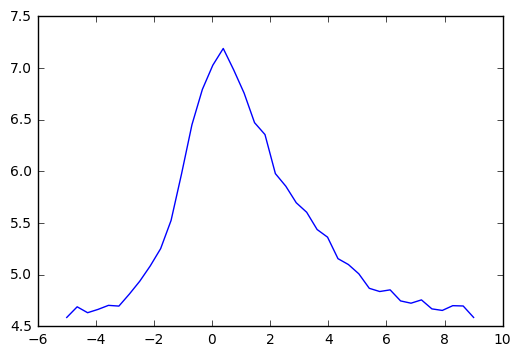

In [1]:
import numpy as np
from matplotlib import pyplot as plt

data = np.loadtxt('emission-line.dat',skiprows=1,delimiter=',')
x = data[:,0]
y = data[:,1]
plt.plot(x,y)
plt.show()

In [2]:


def gaussian(x, mu, sigma):
    return np.exp(-0.5*((x-mu)/sigma)**2)/sigma/np.sqrt(2*np.pi)

#Define Model

def TwoGaussPlusBackground(Param):
    OutSpectrum = Param[0] + (Param[1] * gaussian(x,Param[2],Param[3])) + (Param[4] * gaussian(x,Param[5],Param[6]))
    return OutSpectrum
#Define likelihood

def LnLike(Param,x,y):
    model = TwoGaussPlusBackground(Param)
    #1/(0.05^2) = 400
    inv_sigma2 = 400
    return -0.5*(np.sum(((y-model)**2)*inv_sigma2))

#Define Prior

def lnPrior(Param):
    mumax = 6.0
    mumin = -2.0
    sigmamax = 4.0
    sigmamin = 0.0
    Amax = 5.0
    Amin = 0.0 
    bgmax = 6.0
    bgmin = 0.0
    if (mumin <= Param[2],Param[5]<= mumax) and  (sigmamin <= Param[3],Param[6] <= sigmamax) and \
    (Amin <= Param[1],Param[4] <= Amax) and  (bgmin <= Param[0] <= bgmax):
        lnprior=0.0
    else:
        lnprior = -np.inf
    return lnprior

#Define Posterior

def LnProb(Param,x,y):
    lp = lnPrior(Param)
    if not np.isfinite(lp):
        return -np.inf
    return lp + LnLike(Param,x,y)
    
    


In [3]:
#For our initial guess, let's use our results from hw4, plus some guesses

mu1=0.131
mu2=1.675
sigma1=1.03
sigma2=2.16
A1=4.0
A2=4.0
bg=4.5

Param = np.zeros(7)
Param[0]=bg
Param[1]=A1
Param[2]=mu1
Param[3]=sigma1
Param[4]=A2
Param[5]=mu2
Param[6]=sigma2

print lnPrior(Param)



0.0


### Part B

Load the `emcee` package.

Remember the goal for this problem: to sample our log-posterior for all 7 parameters because doing so exactly is too computationally expensive.  We will use an `emcee.EnsembleSampler` object to sample our space.  `EnsembleSampler` objects need certain information at instantiation: number of dimensions our walkers will travel through, number of walkers, and the function they are sampling (our log-posterior).  The samplers also take certain keyword arguments, such as a list of additional arguments passed to the log-posterior function.
Consider reading the docs (https://media.readthedocs.org/pdf/emcee/stable/emcee.pdf#page=29).  The website linked above also contains information.

For this part, define the number of dimensions and number of walkers.  Instantiate an `EnsembleSampler` object (by assigning it to a variable).  Run the sampler by calling its `run_mcmc` method which needs two arguments: the initial positions of the walkers and the number of steps.  Make sure the initial positions of the walkers are within the allowed bounds as defined by the prior.

In [4]:
nwalkers=100
ini_bg= bg + 0.01*np.random.randn(nwalkers)
ini_A1= A1 + 0.01*np.random.randn(nwalkers)
ini_mu1= mu1 + 0.005*np.random.randn(nwalkers)
ini_sigma1= sigma1 + 0.005*np.random.randn(nwalkers)
ini_A2= A2 + 0.01*np.random.randn(nwalkers)
ini_mu2= mu2 + 0.005*np.random.randn(nwalkers)
ini_sigma2= sigma2 + 0.005*np.random.randn(nwalkers)

In [5]:
pos=[ini_bg] + [ini_A1] + [ini_mu1] + [ini_sigma1] + [ini_A2] +[ini_mu2] + [ini_sigma2]
posNew=(np.array(pos)).T

In [6]:
initial_lnprior=np.zeros(nwalkers)
for i in np.arange(100):
    paramtemp=posNew[i,:]
    initial_lnprior[i]=lnPrior(paramtemp)

In [7]:
ndim=Param.shape[0]
print ndim
numsims=500

import emcee
samplerNew = emcee.EnsembleSampler(nwalkers, ndim, LnProb, args=(x,y))
samplerNew.run_mcmc(posNew, numsims)


7


(array([[ 4.64910698,  4.11666833,  0.16990674,  1.07624519,  6.42848995,
          1.6345204 ,  2.15747168],
        [ 4.63743706,  3.5407615 ,  0.17627811,  0.99424382,  6.95943306,
          1.57719867,  2.28784795],
        [ 4.69213615,  4.63634177,  0.13847356,  1.08900708,  5.22665462,
          1.85731517,  2.01441871],
        [ 4.6644194 ,  3.50293745,  0.15233369,  0.97714421,  6.86034504,
          1.53466909,  2.17643621],
        [ 4.64995755,  4.12545112,  0.14865326,  1.03809537,  6.26600152,
          1.79218125,  2.18284748],
        [ 4.64318277,  3.94109444,  0.09187172,  1.03820396,  6.7061435 ,
          1.6989918 ,  2.2120969 ],
        [ 4.63357435,  3.8249358 ,  0.08741774,  1.02576346,  6.54969343,
          1.64240578,  2.13812313],
        [ 4.67397456,  4.51062104,  0.10942762,  1.10464063,  5.43101398,
          1.83133656,  1.99943162],
        [ 4.62980875,  3.48277083,  0.11789031,  0.99021839,  7.13068021,
          1.55125364,  2.1955272 ],
        [ 

### Part C

Plot the acceptance fraction of each walker.  Also plot the evolution of the walkers, which is accessed va `EnsembleSampler.chain`.  You may notice the distribution of walkers is very thin at the beginning of the evolution; we only want to consider a 'burnt-in' chain otherwise our results will be biased towards the initial positions of the walkers.  Remove the part of the chain before where the walkers are burnt-in.

In [8]:
chain=samplerNew.chain
lnprob=samplerNew.lnprobability
acceptance=samplerNew.acceptance_fraction

print chain.shape
print lnprob.shape
print acceptance.shape

(100, 500, 7)
(100, 500)
(100,)


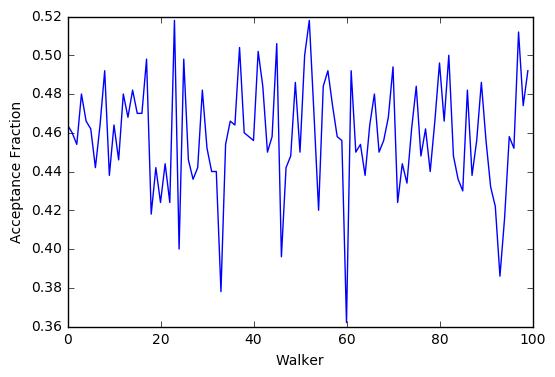

In [9]:
plt.xlabel('Walker')
plt.ylabel('Acceptance Fraction')
plt.plot(acceptance)
plt.show()

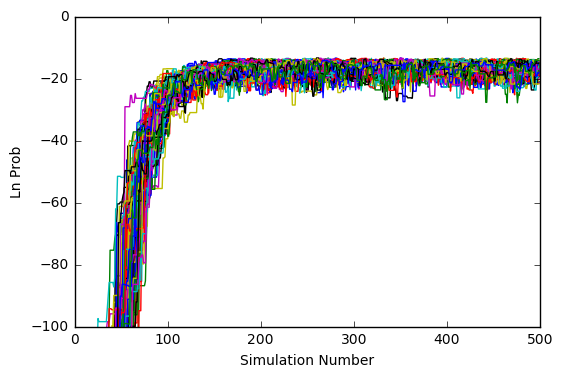

In [10]:
index=np.arange(numsims)

plt.axis([0,numsims,-100,-0])

plt.xlabel('Simulation Number')
plt.ylabel('Ln Prob')

for i in range(nwalkers):
    plt.plot(index,lnprob[i,0:numsims])
plt.show()

In [11]:
burnin=250
ndim=chain.shape[2]

lnprob2=lnprob[:,burnin:].reshape((-1))
temp=chain[:,burnin:,0:ndim]
sample=temp.reshape(((numsims-burnin)*nwalkers,ndim))

print lnprob2.shape
print sample.shape

(25000,)
(25000, 7)


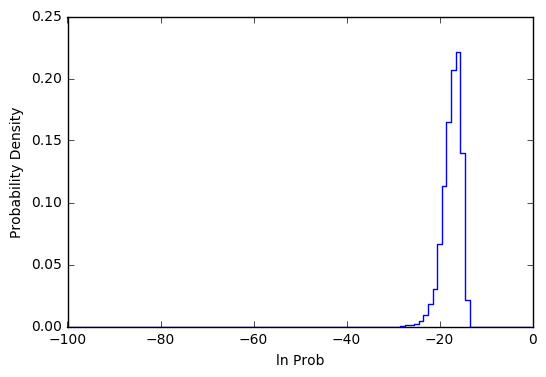

In [12]:
numbins=100
lnprobmin=-100.0
lnprobmax=-0.0
lnprob_hist=np.array(np.histogram(lnprob2,bins=numbins,range=[lnprobmin,lnprobmax],density=1))
lnprob_hist_y=lnprob_hist[0]
temp=lnprob_hist[1]
binsize=temp[1]-temp[0]
lnprob_hist_x=lnprobmin+0.5*binsize+binsize*np.arange(numbins)
plt.xlabel('ln Prob')
plt.ylabel('Probability Density')
plt.plot(lnprob_hist_x,lnprob_hist_y,drawstyle='steps')
out=np.array([lnprob_hist_x,lnprob_hist_y])
plt.show()


Populating the interactive namespace from numpy and matplotlib


/home/collin/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['ndim', 'sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


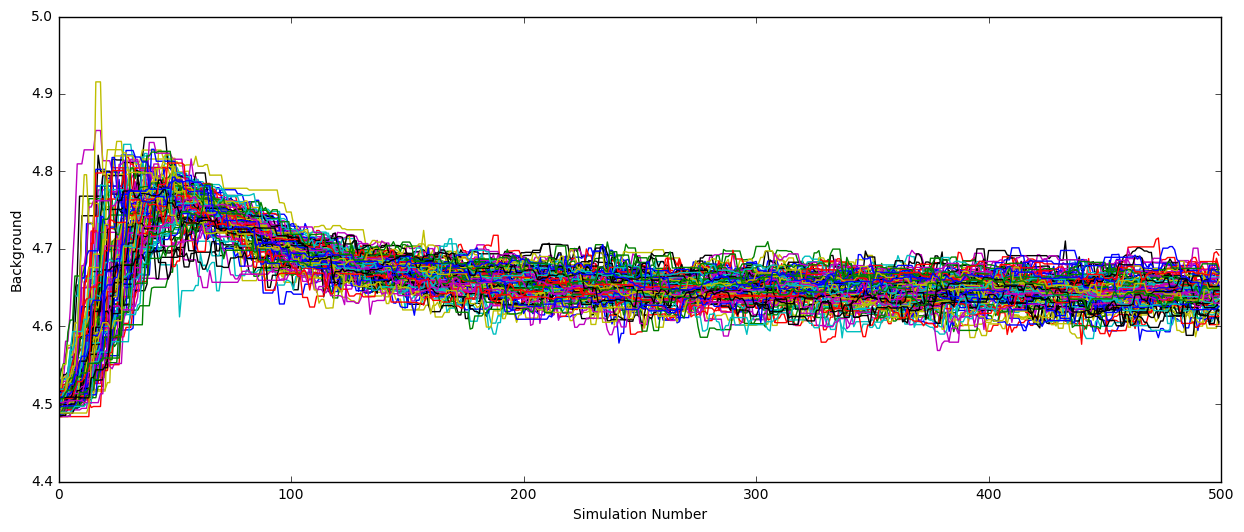

In [13]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 6)
plt.xlabel('Simulation Number')
plt.ylabel('Background')

for i in range(nwalkers):
    plt.plot(index,chain[i,0:numsims,0])


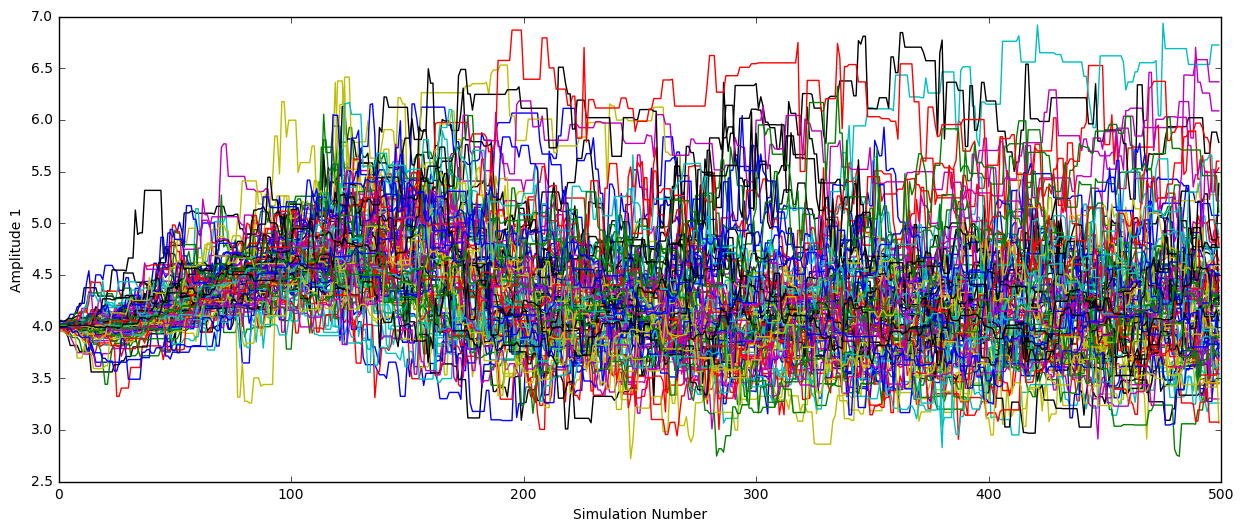

In [14]:
pylab.rcParams['figure.figsize'] = (15, 6)
plt.xlabel('Simulation Number')
plt.ylabel('Amplitude 1')

for i in range(nwalkers):
    plt.plot(index,chain[i,0:numsims,1])


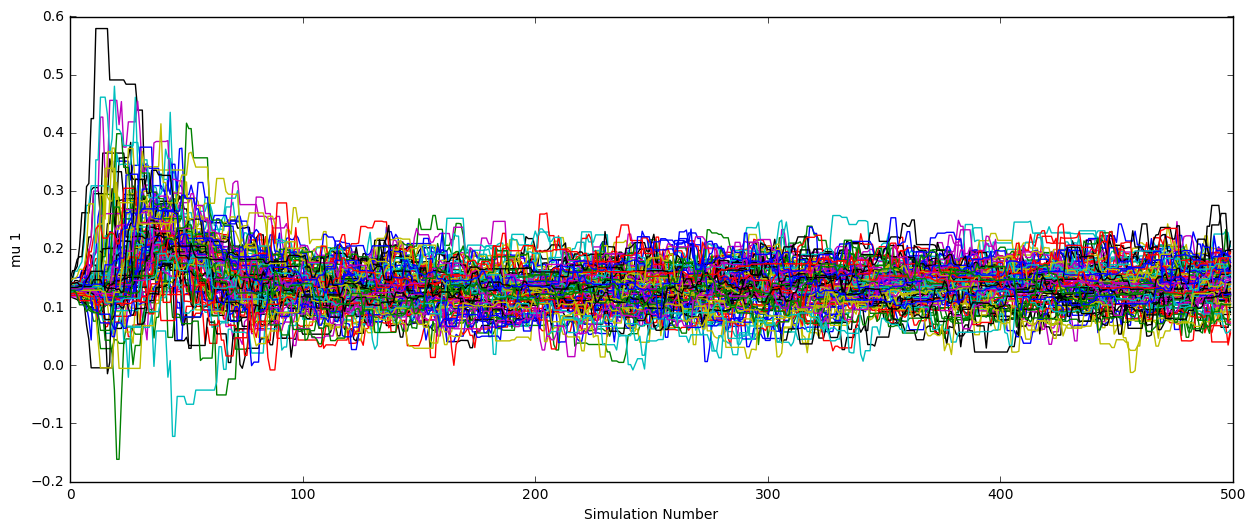

In [15]:
pylab.rcParams['figure.figsize'] = (15, 6)
plt.xlabel('Simulation Number')
plt.ylabel('mu 1')

for i in range(nwalkers):
    plt.plot(index,chain[i,0:numsims,2])


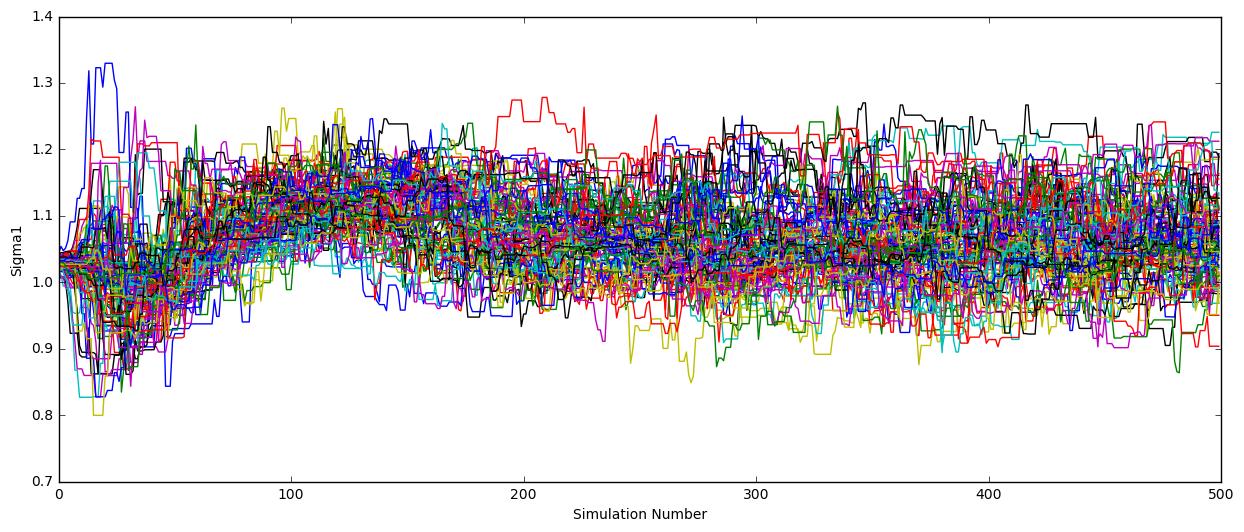

In [16]:
pylab.rcParams['figure.figsize'] = (15, 6)
plt.xlabel('Simulation Number')
plt.ylabel('Sigma1')

for i in range(nwalkers):
    plt.plot(index,chain[i,0:numsims,3])


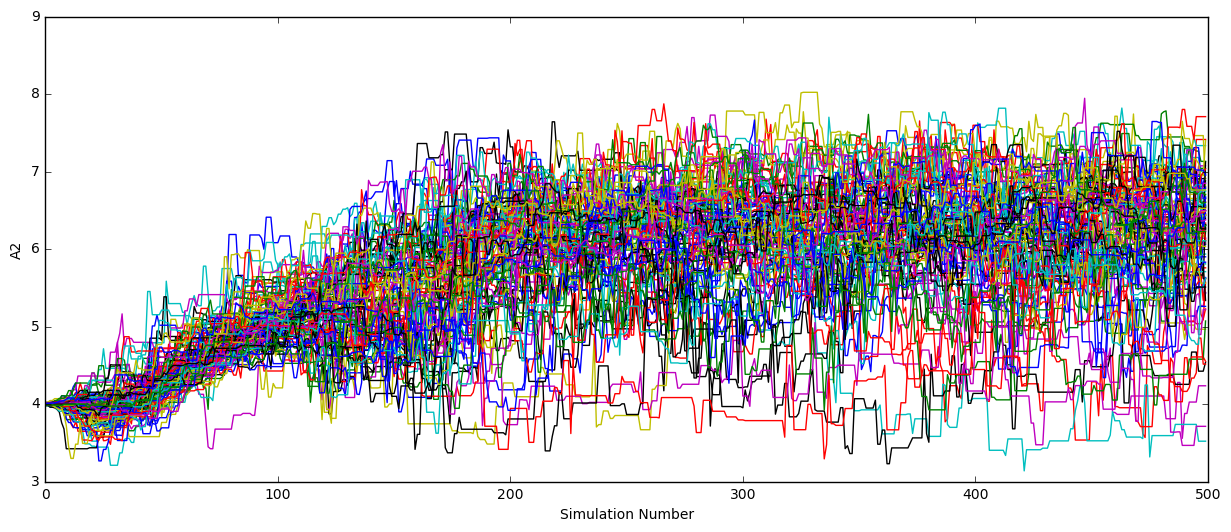

In [17]:
pylab.rcParams['figure.figsize'] = (15, 6)
plt.xlabel('Simulation Number')
plt.ylabel('A2')
for i in range(nwalkers):
    plt.plot(index,chain[i,0:numsims,4])


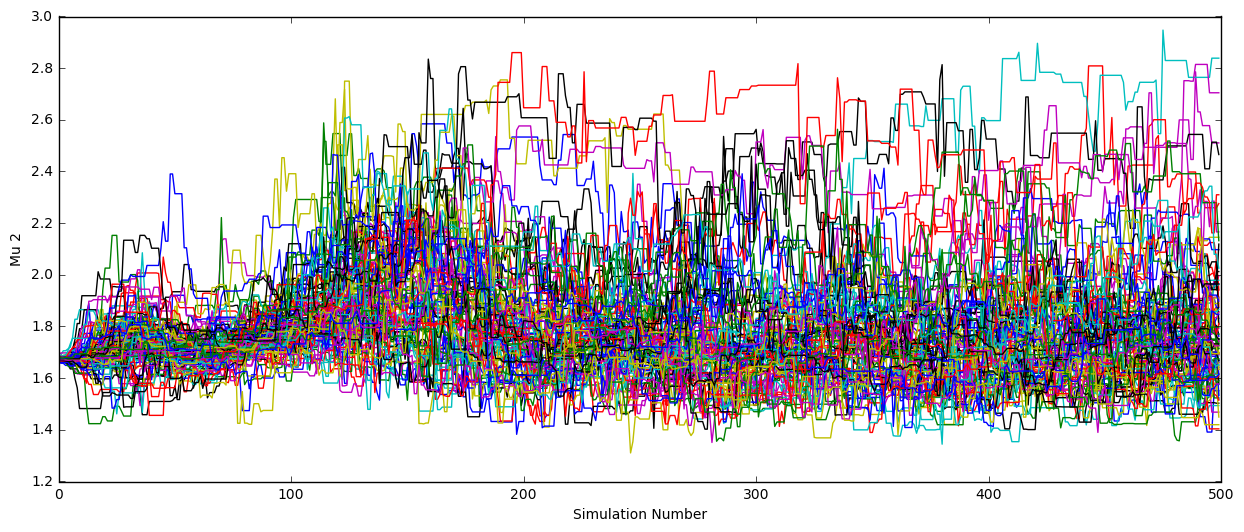

In [18]:
pylab.rcParams['figure.figsize'] = (15, 6)
plt.xlabel('Simulation Number')
plt.ylabel('Mu 2')

for i in range(nwalkers):
    plt.plot(index,chain[i,0:numsims,5])


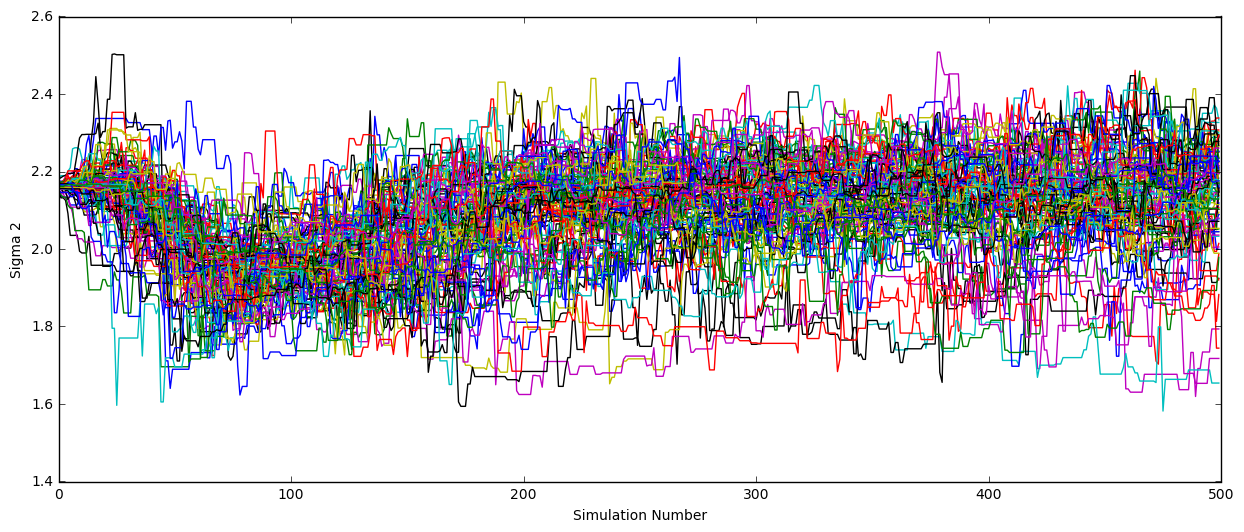

In [19]:
pylab.rcParams['figure.figsize'] = (15, 6)
plt.xlabel('Simulation Number')
plt.ylabel('Sigma 2')

for i in range(nwalkers):
    plt.plot(index,chain[i,0:numsims,6])


Make histograms of convergence for parameters

In [20]:
def MakeHistogram(samples, index, numbins):
    numout=len(samples)
    comp=samples[0:numout,index]
    comp_histogram=np.array(np.histogram(comp,bins=numbins,range=[comp.min(),comp.max()],density=1))
    comp_histogram_y=comp_histogram[0]
    temp=comp_histogram[1]
    binsize=temp[1]-temp[0]
    comp_histogram_x=comp.min()+0.5*binsize+binsize*np.arange(numbins)
    return comp_histogram_x,comp_histogram_y

print chain.shape
burnin=250
ndim=chain.shape[2]

lnprob2=lnprob[:,burnin:].reshape((-1))
temp=chain[:,burnin:,0:ndim]
sample=temp.reshape(((numsims-burnin)*nwalkers,ndim))

print lnprob2.shape
print sample.shape

(100, 500, 7)
(25000,)
(25000, 7)


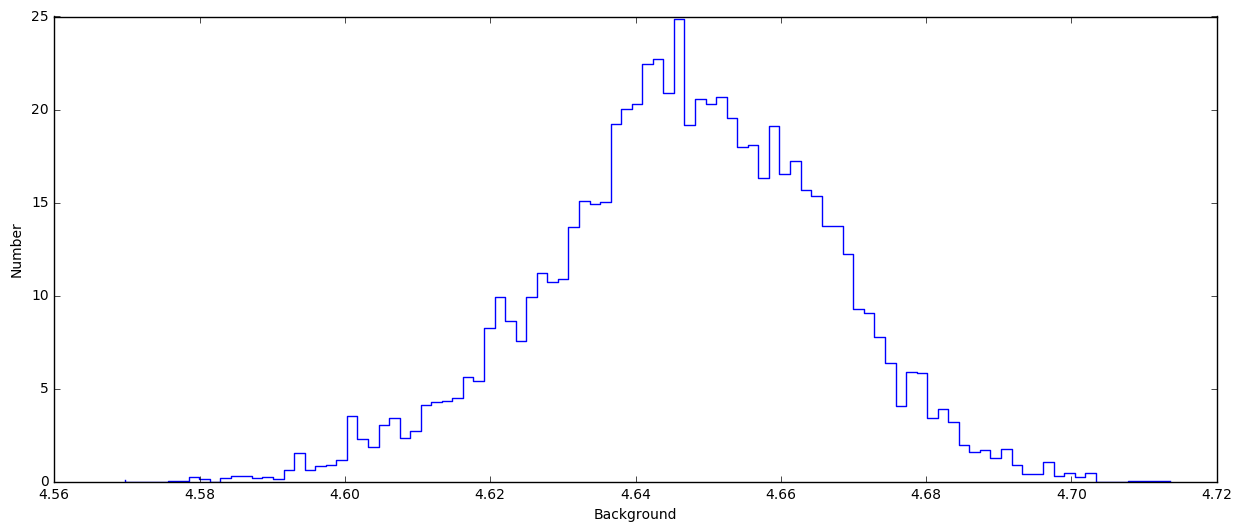

In [21]:
index=0
comp_hist_0_x,comp_hist_0_y=MakeHistogram(sample,index,numbins)
plt.xlabel('Background')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

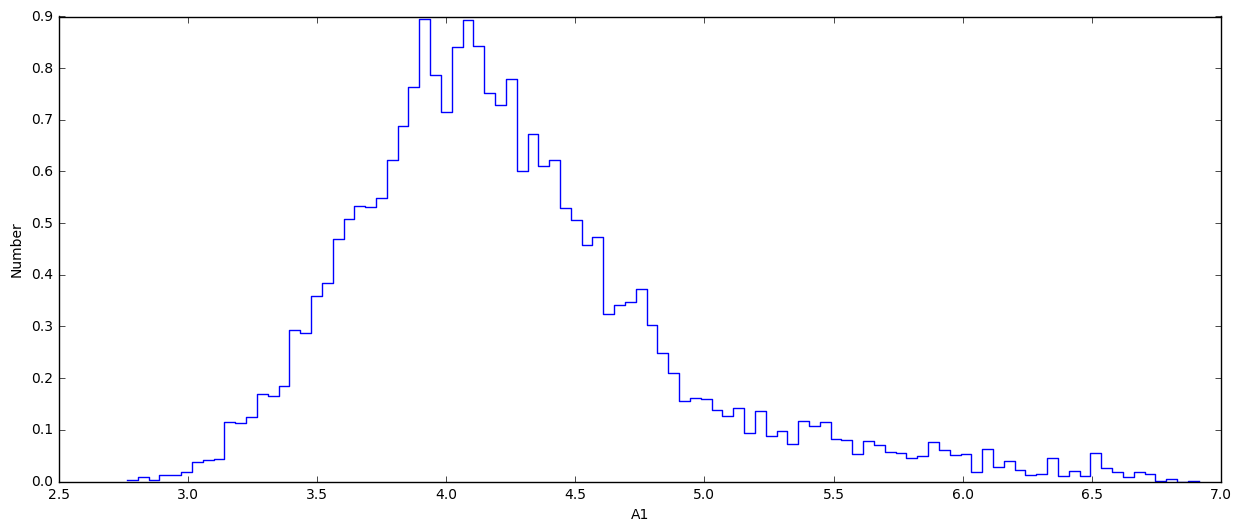

In [22]:
index=1
comp_hist_0_x,comp_hist_0_y=MakeHistogram(sample,index,numbins)
plt.xlabel('A1')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

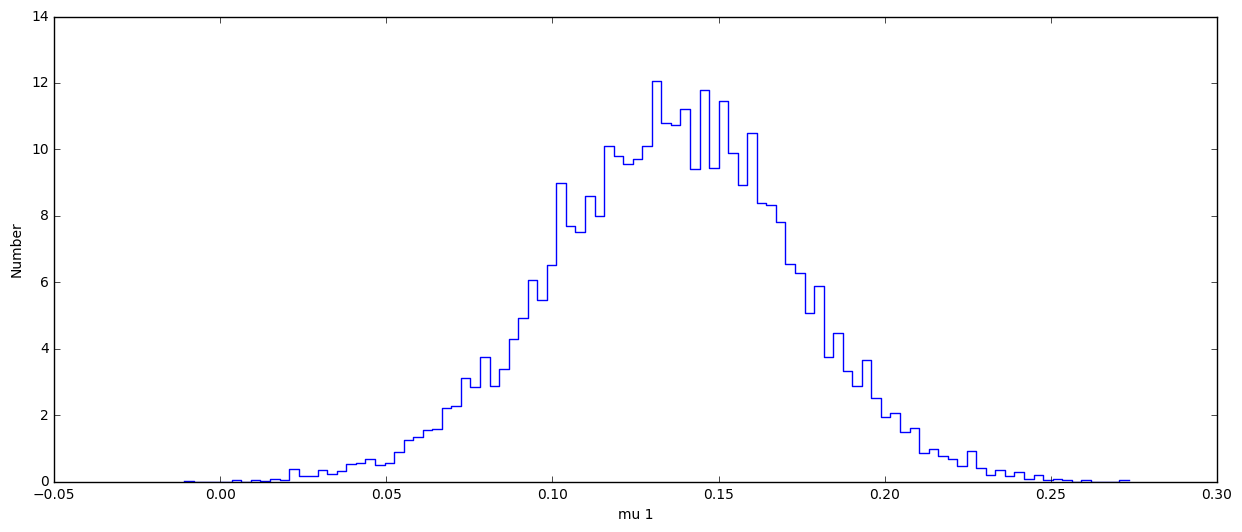

In [23]:
index=2
comp_hist_0_x,comp_hist_0_y=MakeHistogram(sample,index,numbins)
plt.xlabel('mu 1')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

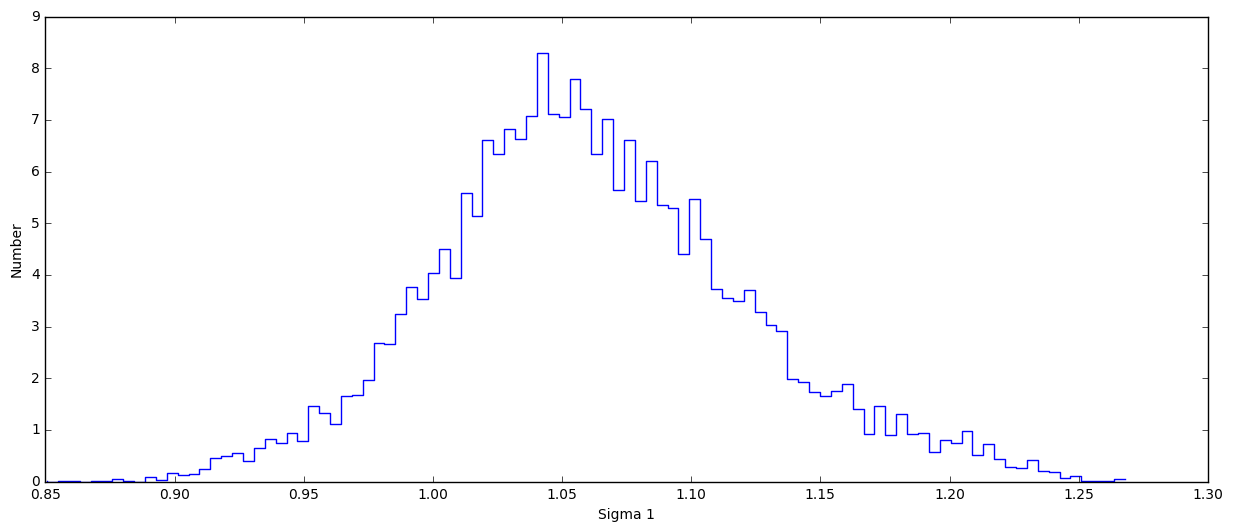

In [24]:
index=3
comp_hist_0_x,comp_hist_0_y=MakeHistogram(sample,index,numbins)
plt.xlabel('Sigma 1')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

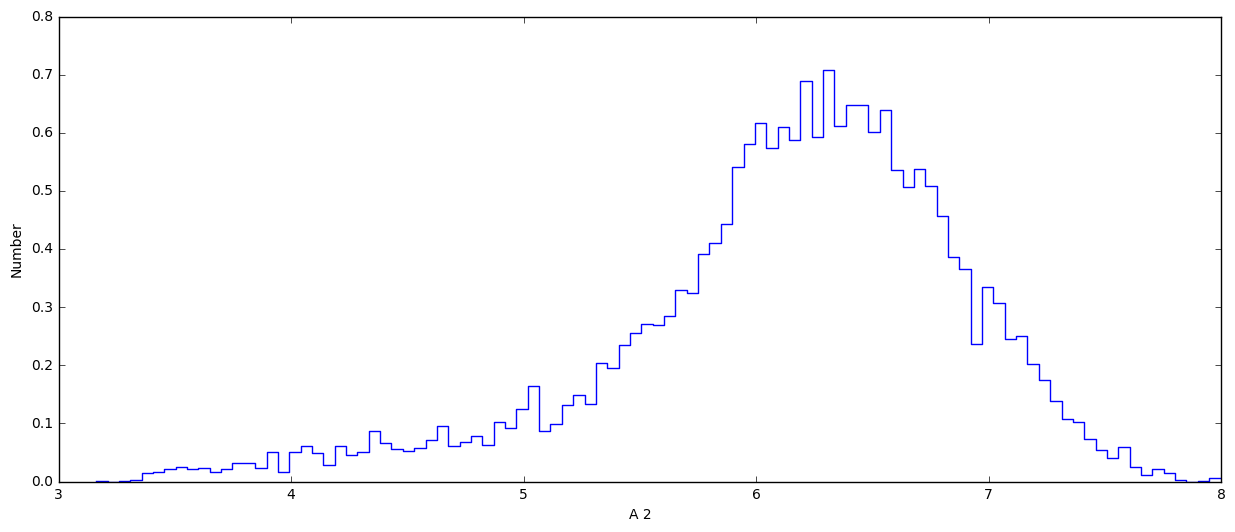

In [25]:
index=4
comp_hist_0_x,comp_hist_0_y=MakeHistogram(sample,index,numbins)
plt.xlabel('A 2')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

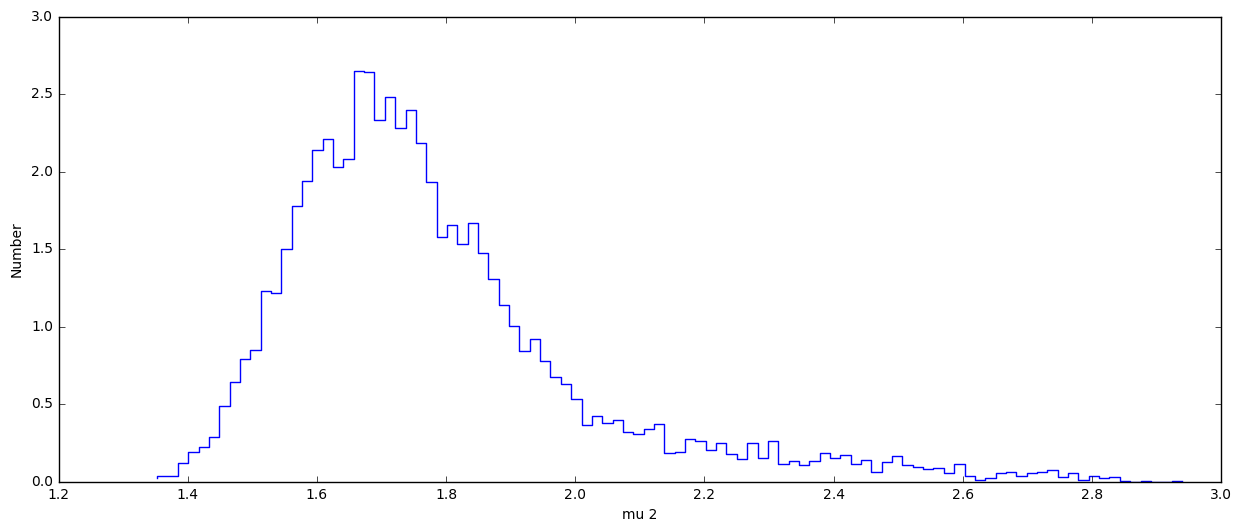

In [26]:
index=5
comp_hist_0_x,comp_hist_0_y=MakeHistogram(sample,index,numbins)
plt.xlabel('mu 2')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

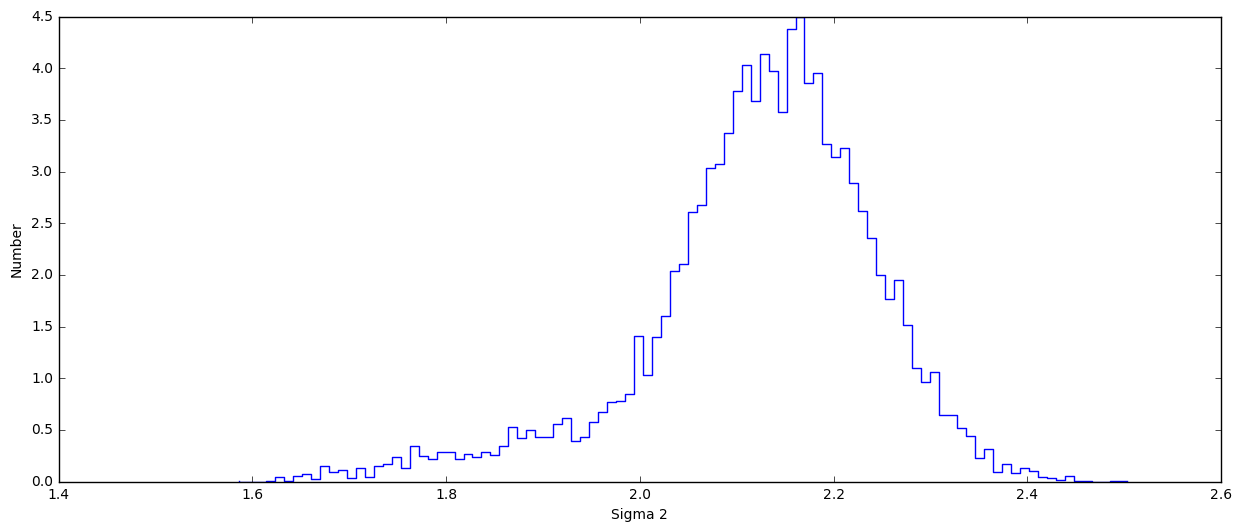

In [27]:
index=6
comp_hist_0_x,comp_hist_0_y=MakeHistogram(sample,index,numbins)
plt.xlabel('Sigma 2')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

### Part D 

Using `EnsembleSampler.chain`, find a point estimate  and 95% credible region for each of the parameters.

In [28]:
percent_regions=[1.0-0.9973,1.0-0.9545,1.0-0.6827,0.5,0.6827,0.9545,0.9973]

confidence_regions_params=np.zeros([7,ndim])

numsamples=len(sample)

for i in np.arange(ndim):
    temp=sample[:,i]
    x2=np.sort(temp)
    f2=np.array(range(numsamples))/float(numsamples)
    confidence_regions_params[0:7,i]=np.interp(percent_regions,f2,x2)

In [29]:
print 'The median value of the background is ',confidence_regions_params[4,0]
print 'The 95 percent region of the background is ',confidence_regions_params[6,0]-confidence_regions_params[1,0]

The median value of the background is  4.65706595422
The 95 percent region of the background is  0.0852093932169


In [30]:
print 'The median value of Amplitude 1 is ',confidence_regions_params[4,1]
print 'The 95 percent region of Amplitude 1 is ',confidence_regions_params[6,1] -confidence_regions_params[1,1]

The median value of Amplitude 1 is  4.42904357891
The 95 percent region of Amplitude 1 is  3.19325950427


In [32]:
print 'The median value of mu 1 is ',confidence_regions_params[4,2]
print 'The 95 percent region of mu1 is ',confidence_regions_params[6,2]-confidence_regions_params[1,2]

The median value of mu 1 is  0.154753569816
The 95 percent region of mu1 is  0.165236889169


In [33]:
print 'The median value of sigma 1 is ',confidence_regions_params[4,3]
print 'The 95 percent region of sigma 1 is ',confidence_regions_params[6,3]-confidence_regions_params[1,3]

The median value of sigma 1 is  1.08776319275
The 95 percent region of sigma 1 is  0.270912887284


In [34]:
print 'The median value of Amplitude 2 is ',confidence_regions_params[4,4]
print 'The 95 percent region of Amplitude 2 is ',confidence_regions_params[6,4]-confidence_regions_params[1,4]

The median value of Amplitude 2 is  6.5436439172
The 95 percent region of Amplitude 2 is  3.14901954816


In [35]:
print 'The median value of mu 2 is ',confidence_regions_params[4,5]
print 'The 95 percent region of mu 2 is ',confidence_regions_params[6,5]-confidence_regions_params[1,5]

The median value of mu 2 is  1.83200196807
The 95 percent region of mu 2 is  1.25929936445


In [36]:
print 'The median value of sigma 2 is ',confidence_regions_params[4,6]
print 'The 95 percent region of sigma 2 is ',confidence_regions_params[6,6]-confidence_regions_params[1,6]

The median value of sigma 2 is  2.18635241532
The 95 percent region of sigma 2 is  0.527615547474


### Part E

Which 2 parameters do you think would have the highest covariance?  Least?  Why?  Discuss, then plot the joint-distributions of both pairs of parameters.

I would imagine there would be covariance between the background and the amplitude of either gaussian. I would also expect covariance between the two sigma values. I would expect the location of the peak of either gaussian to not be dependent on any other parameter and so I expect either mu to have little covariance with any other parameter.

In [90]:
def PlotDensity(density, pos1out, pos2out):
    delta=density.max()/30.0
    levels=delta+delta*np.arange(30)
    plt.contourf(pos1out,pos2out,density,levels)

def MakeContour(samples, index1, index2, numbins):
     numout=len(samples)
     comp1=samples[0:numout,index1]
     comp2=samples[0:numout,index2]
     binsize1=(comp1.max()-comp1.min())/numbins
     binsize2=(comp2.max()-comp2.min())/numbins
     density=np.zeros([numbins,numbins])
     pos1=(comp1-comp1.min())/binsize1
     pos2=(comp2-comp2.min())/binsize2
     pos1out=comp1.min()+0.5*binsize1+binsize1*np.arange(numbins)
     pos2out=comp2.min()+0.5*binsize2+binsize2*np.arange(numbins)
     for i in range(numout):
        if (long(pos1[i])) < numbins and (long(pos2[i])) < numbins:
            density[long(pos1[i]),long(pos2[i])]=density[long(pos1[i]),long(pos2[i])]+1.0
     return density, pos1out, pos2out


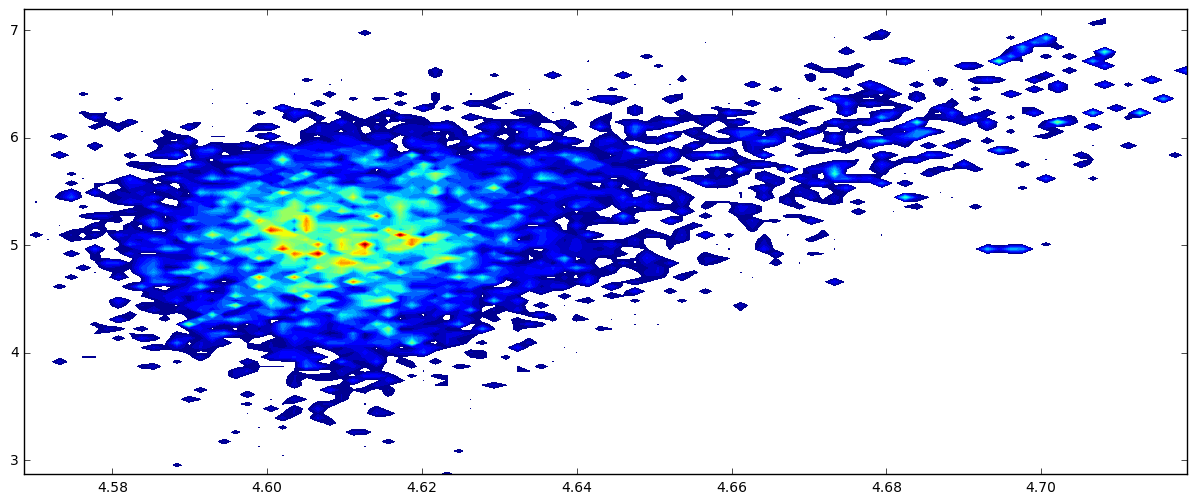

In [91]:
index1=0
index2=1
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

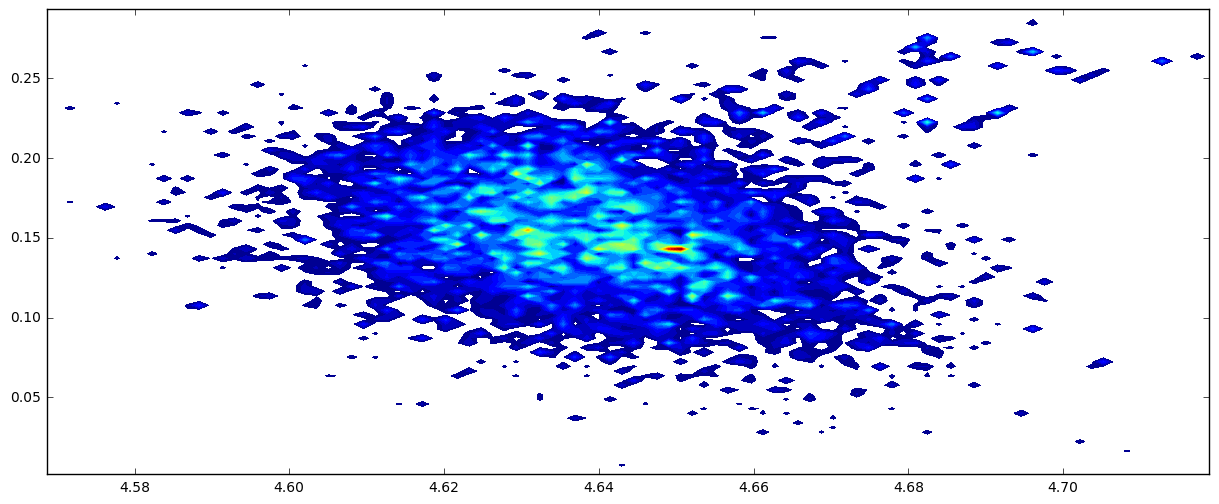

In [92]:
index1=0
index2=2
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

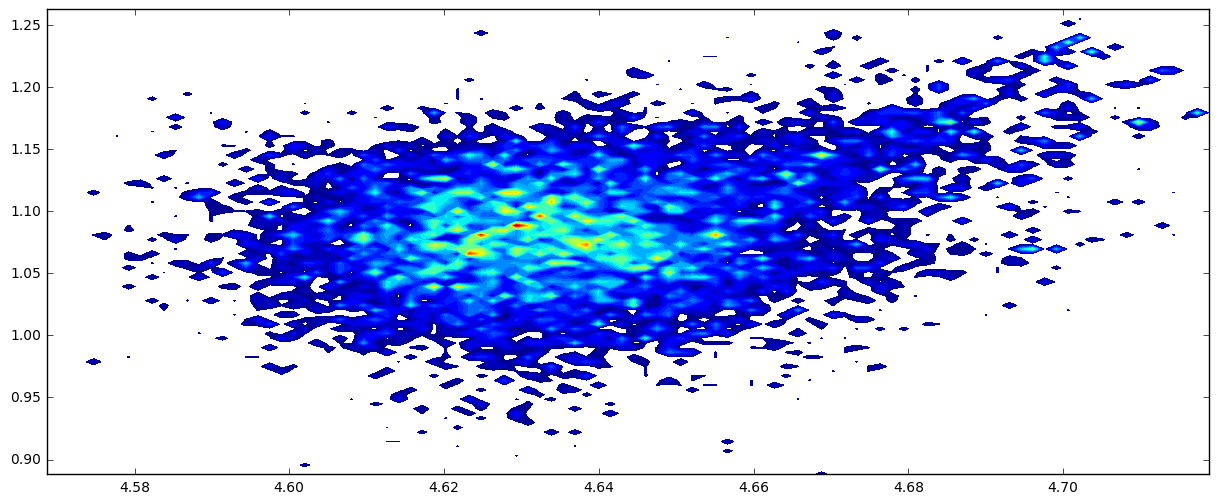

In [93]:
index1=0
index2=3
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

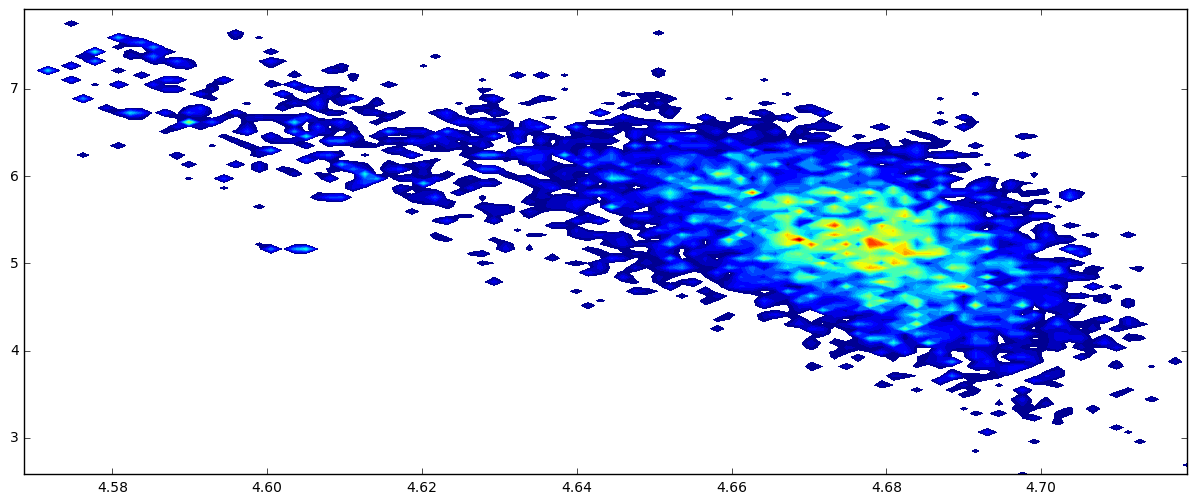

In [94]:
index1=0
index2=4
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

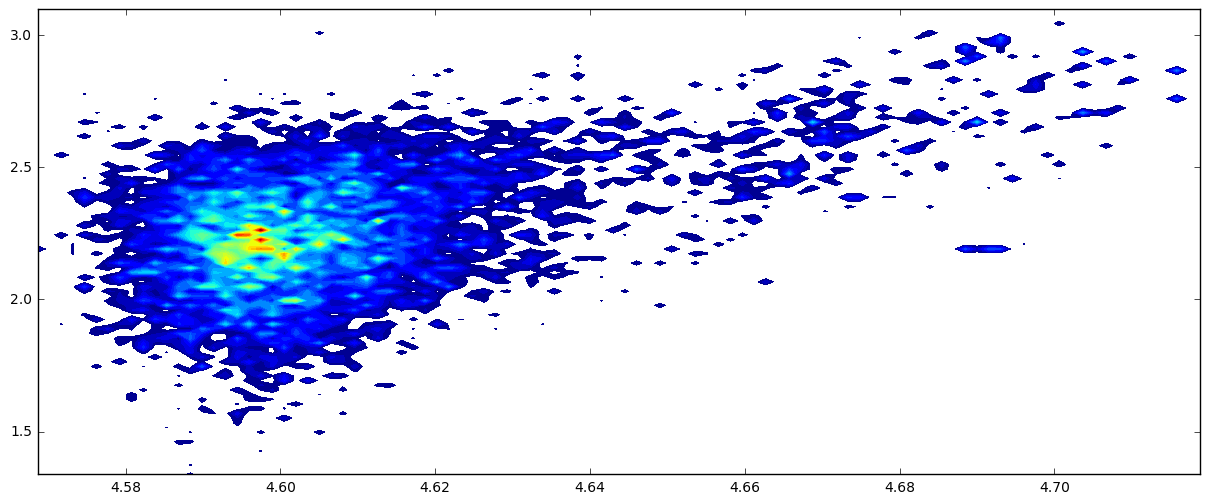

In [95]:
index1=0
index2=5
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

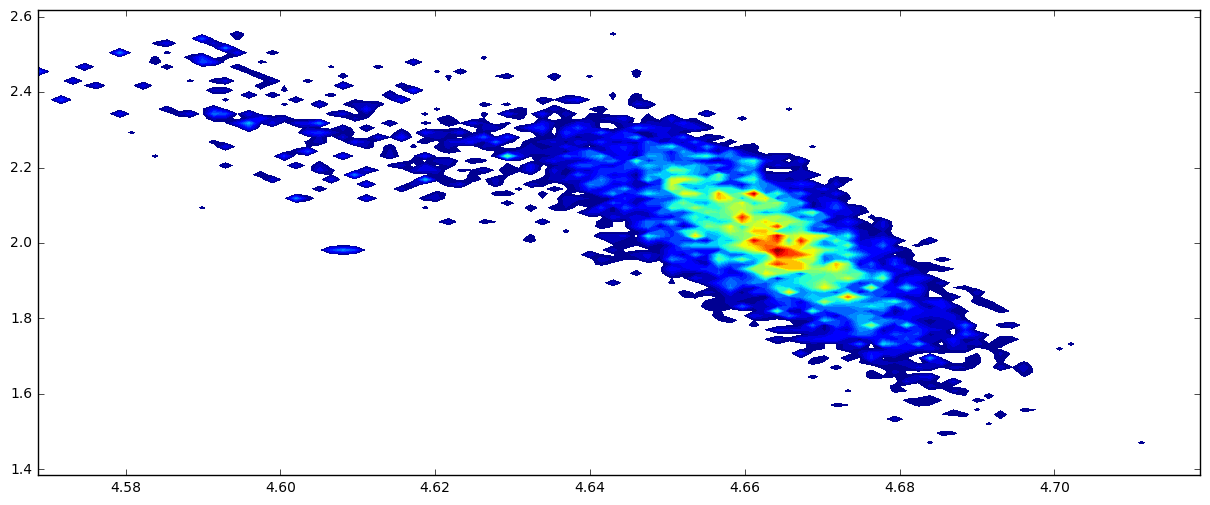

In [96]:
index1=0
index2=6
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

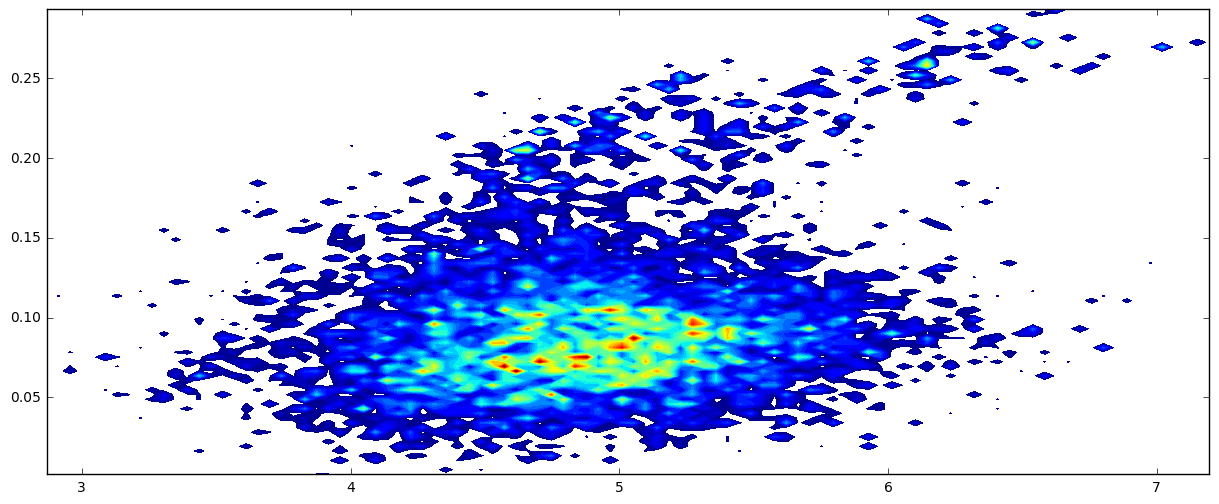

In [97]:
index1=1
index2=2
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

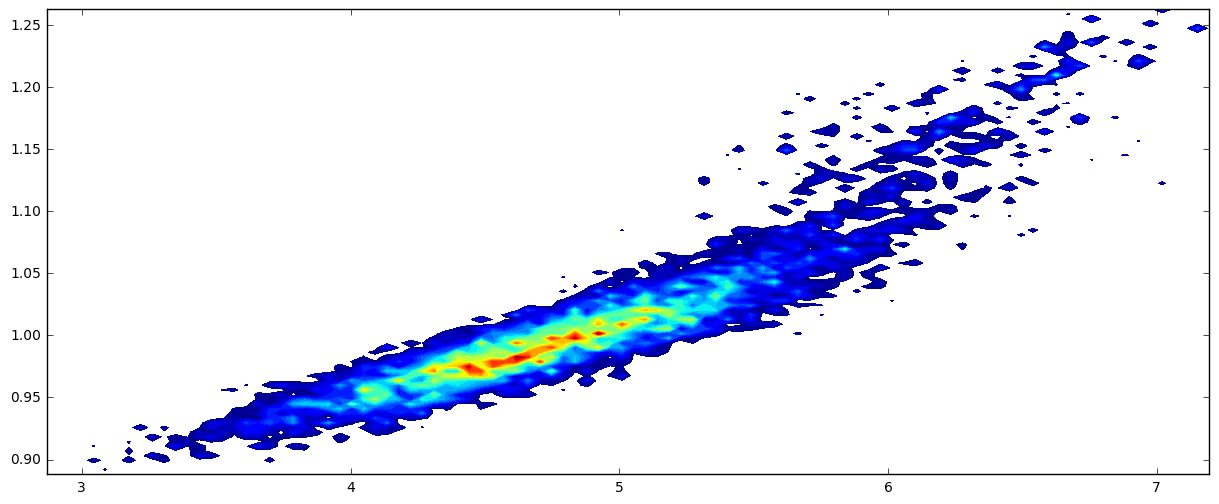

In [98]:
index1=1
index2=3
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

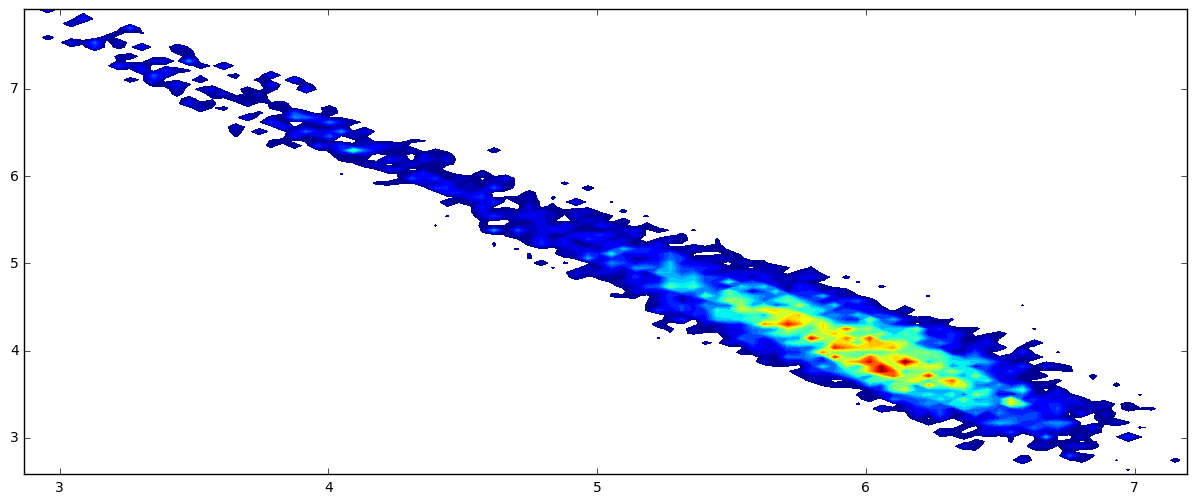

In [99]:
index1=1
index2=4
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

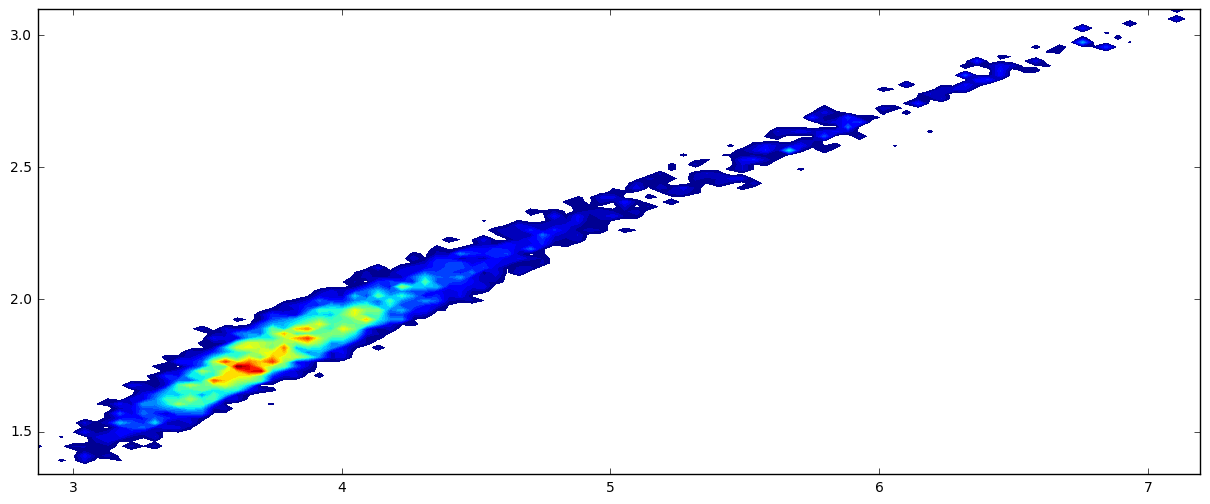

In [100]:
index1=1
index2=5
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

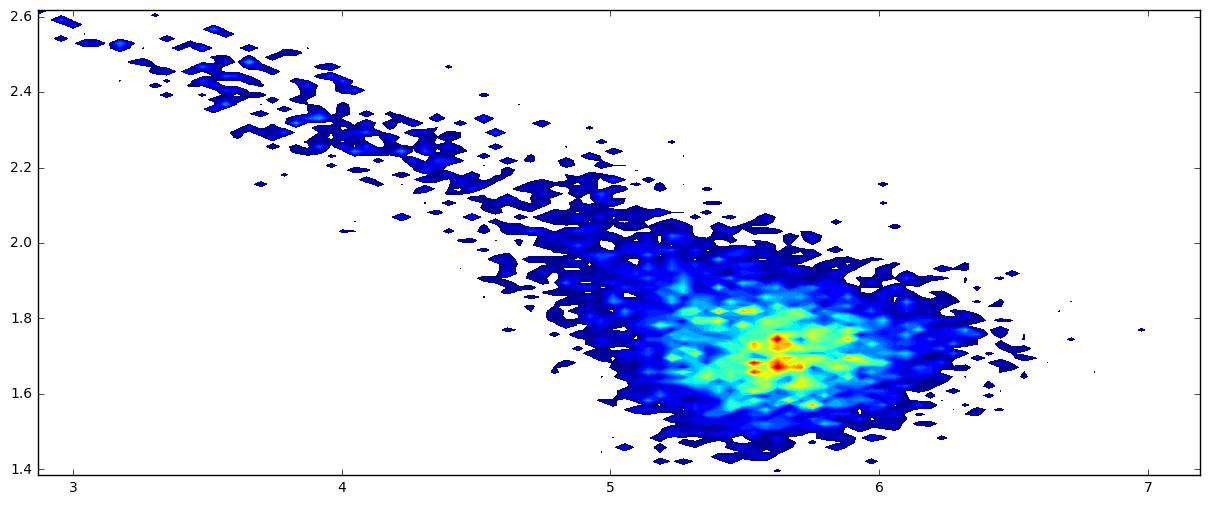

In [101]:
index1=1
index2=6
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

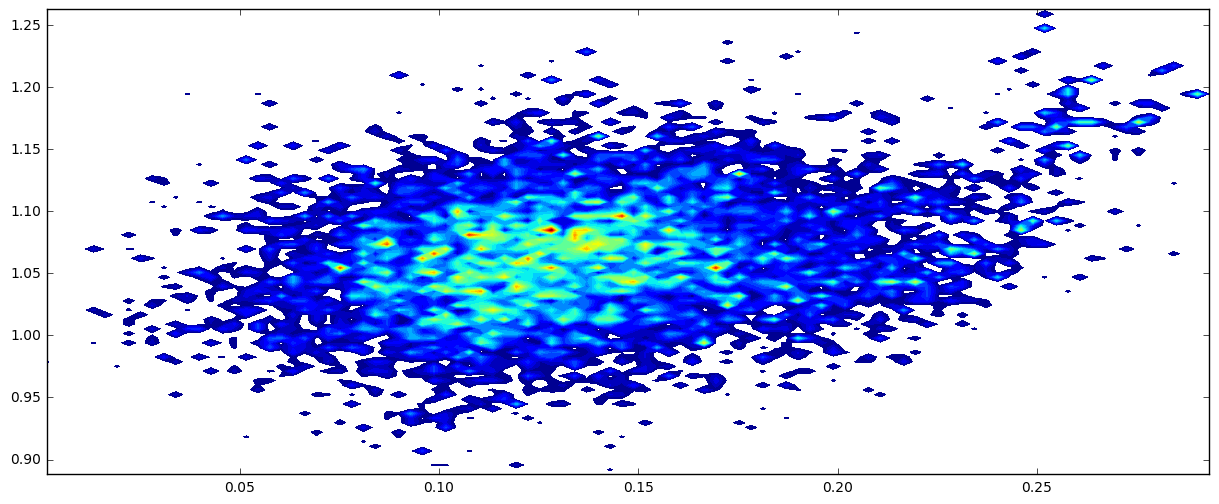

In [102]:
index1=2
index2=3
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

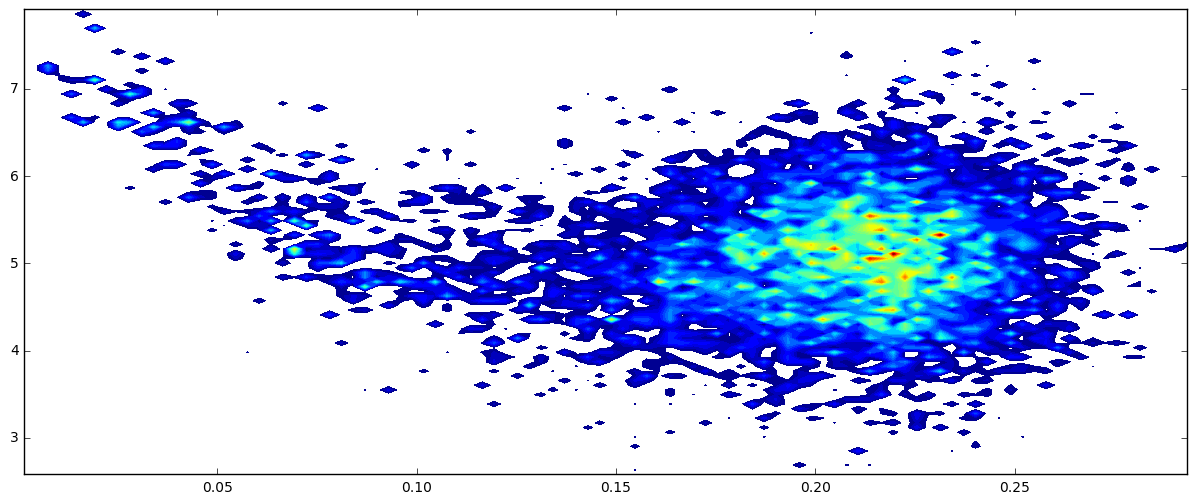

In [103]:
index1=2
index2=4
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

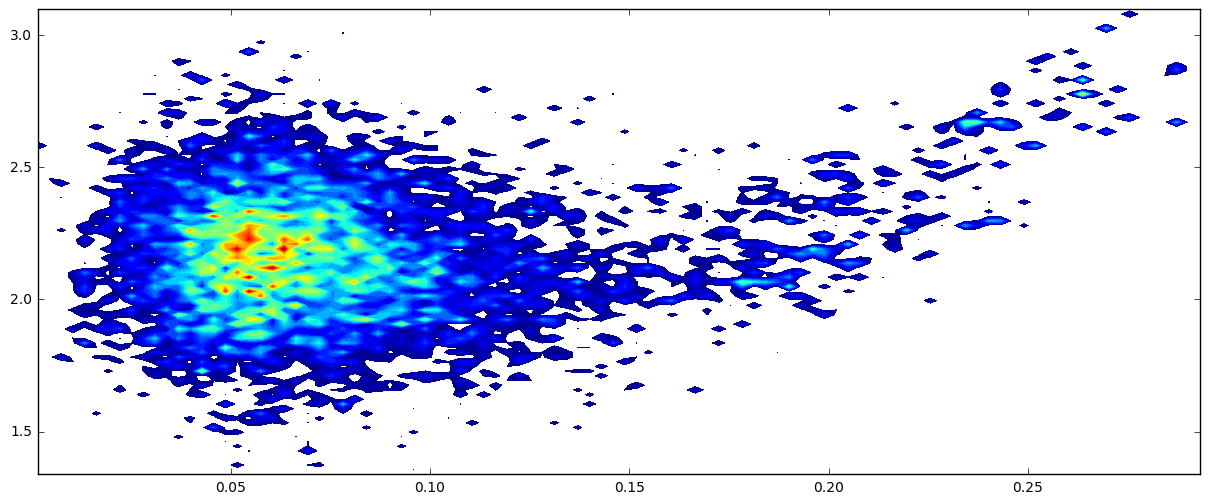

In [104]:
index1=2
index2=5
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

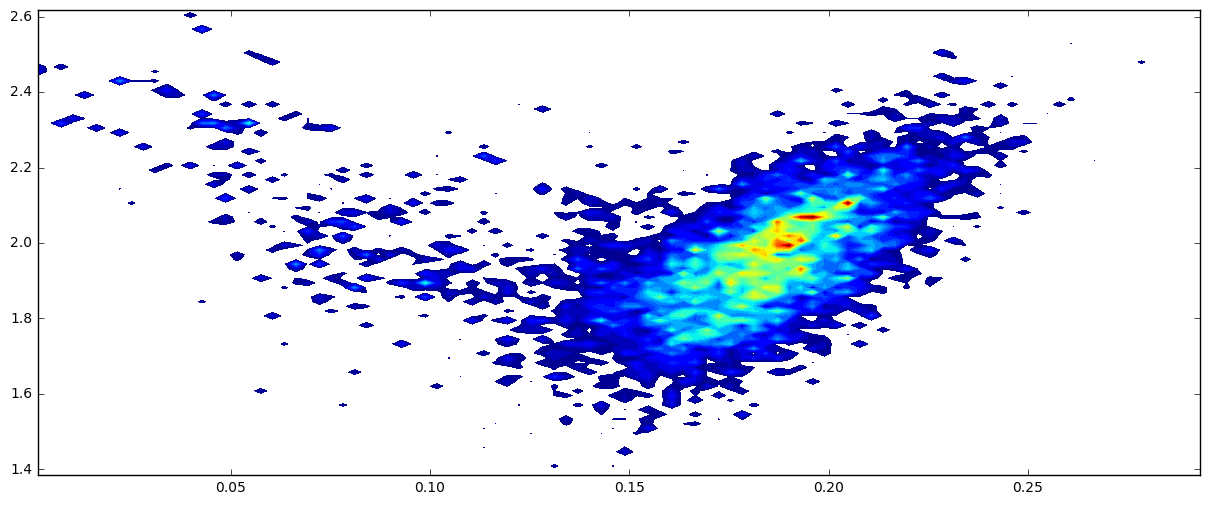

In [105]:
index1=2
index2=6
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

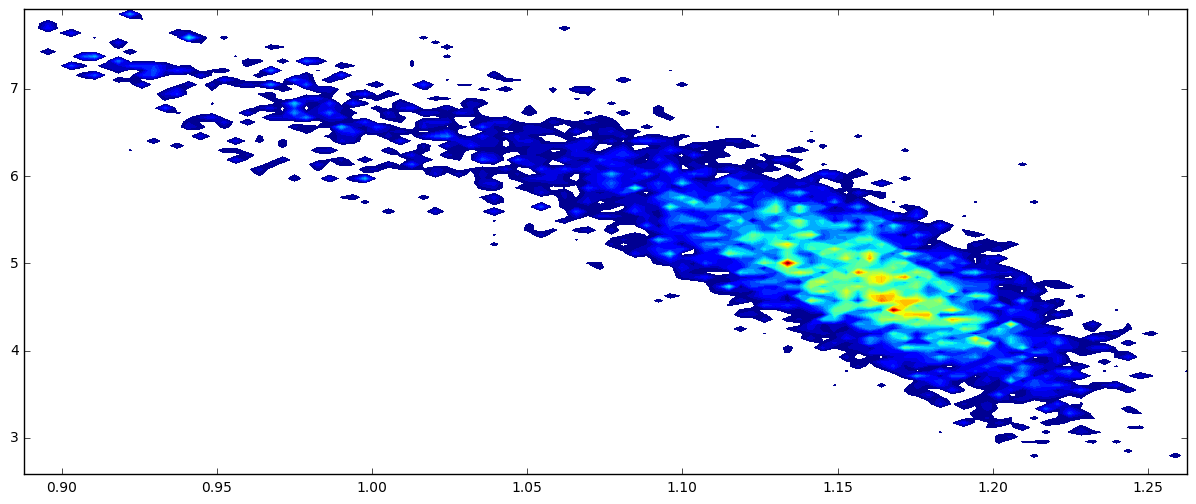

In [106]:
index1=3
index2=4
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

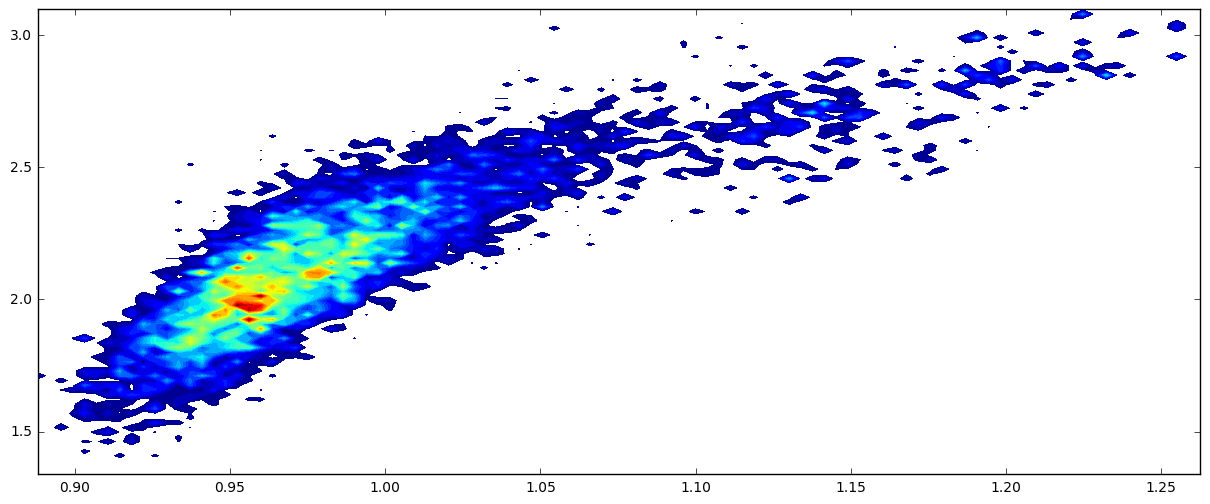

In [107]:
index1=3
index2=5
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

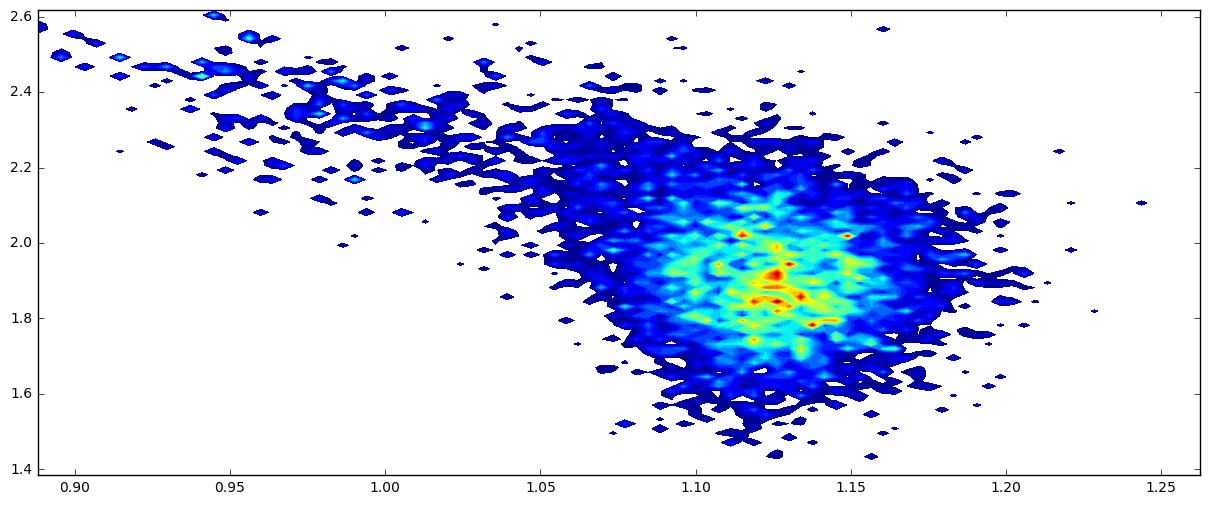

In [108]:
index1=3
index2=6
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

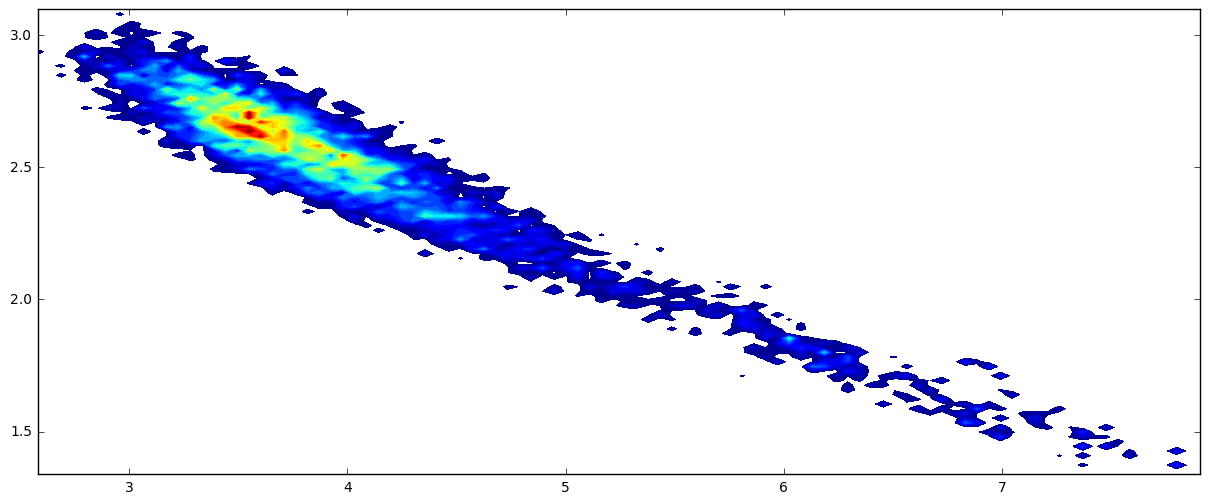

In [109]:
index1=4
index2=5
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

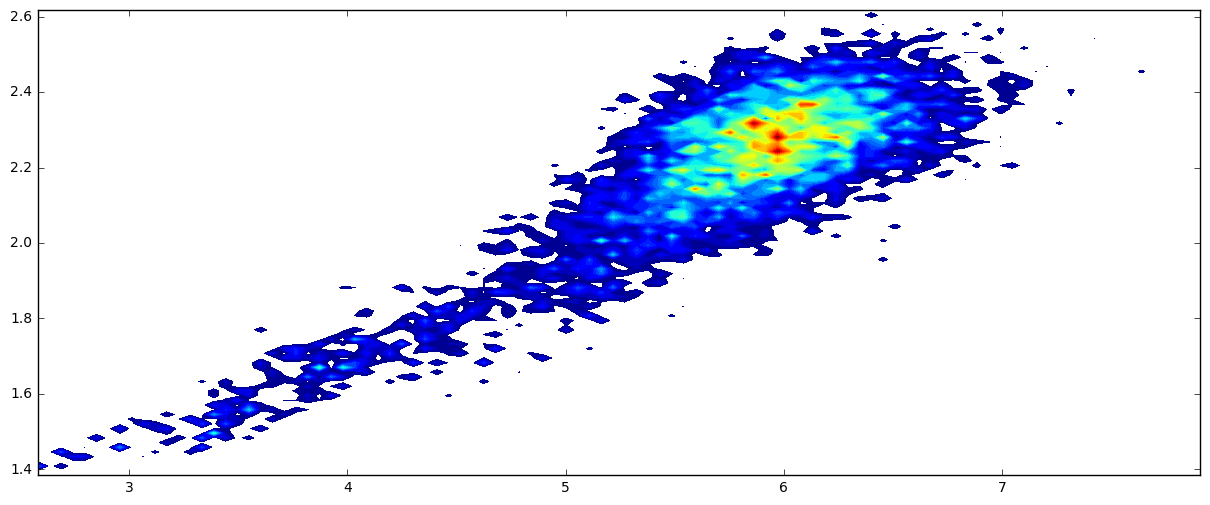

In [110]:
index1=4
index2=6
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

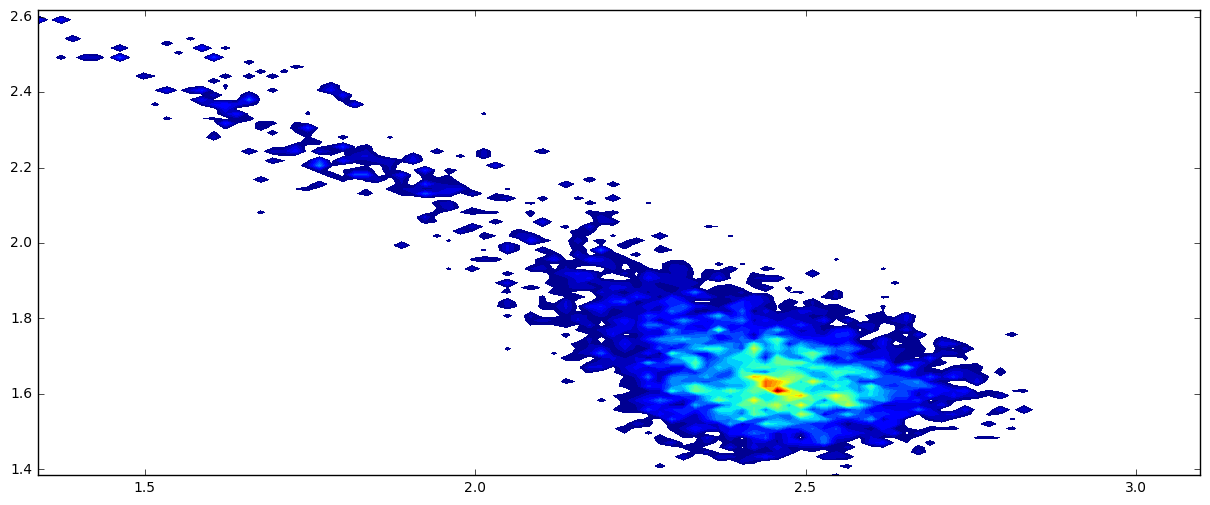

In [111]:
index1=5
index2=6
numbins=100
density, pos1out, pos2out=MakeContour(sample,index1,index2,numbins)
PlotDensity(density,pos1out,pos2out)

Was your answer affirmed?  If you got results you didn't expect, discuss why might the parameters be correlated/uncorrelated.

Surprisingly the background did not seem to have very much covariance with other parameters, upon further reflection I suppose this makes sense because the two gaussians are very weak at either edge of the region, which would allow the background to be highly constrained. In general the amplitudes of a gaussian were covariant with the mu's and sigma's of either gaussian and the mu's were not covariant with most parameters (excluding amplitude).

# Problem 2

Consider a 2D lattice of size $L \times L$.  In this model, we want to randomly assign a value of 0 or 1 to each of the lattice sites in such a way that no two adjacent vertices both take the value of 1 (two lattice sites are adjacent if they share an edge).  A configuration that meets this condition is known as *feasible*.  For now we will pick random configurations such that each feasible configuration has an equal probability, while infeasible configurations have a probability of precisely 0.  One might ask,what is the expected number of 1's in our grid?  That is: 

$$ E \left[ n(X)\right]  = \sum_{\xi} n(\xi) P(\xi)$$
where $\xi$ is a possible configuration.

Write your own MCMC algorithm from scratch to evaluate this expectation value for a grid of length 8.  You are limited to default python and the `numpy` package.

In order to use an MCMC algorithm for this model, you must use a Markov chain whose state space is the set of all feasible configurations.  In order to have a stationary distribution, the Markov chain must be aperiodic and irreducible.  Such a Markov chain can be constructed by the following process.

1. Start in a feasible configuration.

2. For each integer time $t+1$:

    1. Pick a vertex at random, uniformly 
    2. Toss a fair coin 
    3. If the coin is heads and all neighbors of the vertex is 0, set the vertex to 1. Set the vertex to 0 otherwise.
    



In [1]:
import numpy as np
N = np.zeros(64)
A = np.reshape(N,(8,8))

def MCMC():
    for i in range(1000):
        Ai=np.random.randint(8)
        Aj=np.random.randint(8)
        Aij = A[Ai,Aj]
        h=np.random.uniform(0,1,1)
   
        if Aj-1 < 0:
            A1=0
        else:
            A1=A[Ai,Aj-1]
    
        if Aj+1 > 7:
            A2 = 0
        else:
            A2=A[Ai,Aj+1]
    
        if Ai-1 < 0:
            A3=0
        else:
            A3=A[Ai-1,Aj]
    
        if Ai+1 > 7:
            A4=0
        else:
            A4=A[Ai+1,Aj]
        
        if h>0.5:
            if A1 == 0 and A2==0 and A3== 0 and A4 == 0:
                Aij=1
            else:
                Aij=0
        if h<0.5:
            Aij=0
        A[Ai,Aj]=Aij
    return A
   

# running MCMC function 1000 times and creating an array where each index is number of 1s in our MCMC array

s=np.zeros(1000)
for i in range(1000):
    MCMC()
    nonzeros=np.count_nonzero(A)
    s[i]=nonzeros
# Averaging the fraction of 1s in our array to find the expected number of 1s
expectation=(np.sum(s))/1000.
print expectation
    

15.379


### Discussion

Why must we use MCMC for this problem?  Be specific about why we can't sample the state space exactly.

There are 2^64 possible states of an 8x8 array with each location being 0 or 1, to sample every state would be computationally impossible.